In [1]:
"""
You need to run this cell for the code in following cells to work.
"""

%load_ext autoreload
%autoreload 2

%matplotlib notebook

%load_ext tensorboard
%tensorboard --logdir logs --bind_all

import os
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras

import backstage.plots as plots
from backstage.utils import *


# Week 7

__Goals for this week__

We will talk about convolutional neural networks. These networks are most commonly used to process image data, but they can also be applied to various sequential data, such as sound or even text. We will also use some regularization techniques in TensorFlow.

__Feedback__

This lab is a work in progress. If you notice a mistake, notify us or you can even make a pull request. Also please fill the [questionnaire](https://forms.gle/r27nBAvnMC7jbjJ58) after you finish this lab to give us feedback.

## Convolutional Neural Networks

Convolutional neural network (CNN) is one of the most frequently used deep learning architecture. CNNs are often used when we need to process data with a spatial relations between individual inputs. For example, in images there is a spatial relation between individual pixel -- we can not arbitrarily mix them, their position relative to each other is important.

### Convolutional neuron

Consider a greyscale image $\mathbf{X}$. We can represent it as a $height \times width$ matrix of pixel values. With traditional neuron, we would combine all their values into one scalar - a neuron activation:

$$
\sigma\big(b + \sum_{i=1}^{height}\sum_{j=1}^{width} w_{ij}x_{ij}\big) = \sigma\big(b + \sum\mathbf{W} \odot \mathbf{X}\big)
$$

Where $x_{ij}$ is a specific pixel and $w_{ij}$ is a weight for this pixel. We need to have a weight for each pixel. On the other hand, _convolutional neurons_ look only at a small window of the image at the time, e.g. a $3 \times 3$ window. The neuron slides its window across the image and returns the value for each position. Observe the following illustration:


In [ ]:
plots.conv_plot()

On the left, we see the original image $\mathbf{X}$. On the right we see the output of the neuron. We can see how the sliding windows of the neuron shifts across the image as it calculates its ouput. Instead of a scalar, we now have a matrix $\mathbf{Z}$ as an output. For each pixel of $\mathbf{Z}$, we have defined on what pixels it depends, what pixel it "sees". This is called a _receptive field_.

Each value of $\mathbf{Z}$ is calculated with the same neuron, i.e. the weights used for calculations are the same, only the values of the pixels in the window differ. The neuron output for each window $\mathbf{P}$ is defined similarly as the general neuron above:

$$
\sigma\big(b + \sum\mathbf{W} \odot \mathbf{P}\big)
$$

Compared to the general neuron, computational neuron has fewer weights, e.g. for $3 \times 3$ window we have only 9 weights (and 1 bias) and we reuse these weights multiple times for all the windows. The weight matrix $\mathbf{W}$ is also called a _kernel_.

<img src="images/neuron.svg" alt="Convolutional neuron computation" style="width: 60%; margin: 5em auto 2em;"/>
<center><small>Illustration of how one pixel of the output is calculated for one neuron. We look at the window $\mathbf{P}$ and combine the pixel values with our kernel weights $\mathbf{W}$. The weights are trainable parameters of the neuron.</small></center>

#### Multiple input channels

Instead of grayscale image, we can have an RGB image. Such image is in fact a 3D matrix with dimensions of $height \times width \times 3$. When we process a window, we take into account the values from each input channel. Instead of 9 weights, we would now have 27 weights -- 9 weights for each channel:

$$
\sigma\big(b + \sum_{i=1}^{3}\sum\mathbf{W_i} \odot \mathbf{P_i}\big)
$$

where $\mathbf{W_i}$ is a matrix of values for $i$-th channel (e.g. for RGB we would have a weights for red channel) and $\mathbf{P_i}$ is the $i$-th channel values of the sliding window. We can process data with arbitrary number of channels this way.

#### Design decisions

There are multiple design decisions that can be made for a convolutional neuron:

- __Kernel size:__ How large is the sliding windows that slides across the image. We usually use square sized windows with _odd_ and relatively small size, e.g. $3 \times 3$ or $5 \times 5$. We use odd size for the sake of symmetry. $1 \times 1$ is a special case called $1 \times 1$ convolution. In that case each value only depends on the values of one specific pixel. However, we still combine the channels of said input pixel.

- __Stride:__ Stride is the size of the step that the sliding window takes, i.e. how much does the window moves. Usually we use $1 \times 1$ stride, so we move by one pixel in both direction. With this stride the resolution of the output is the same as the resolution of the input. With bigger stride the resolution get smaller.

- __Padding:__ We need to decide how to handle the edges of the image. If we center the $3 \times 3$ window on a top left pixel, parts of the window will overhang. Two basic strategies are used:

  1. We pad the image with zero values.
  2. We only move the window so that it fits the image.
  
  In the first case the ouput has the same dimension as the input. In the second case the output is slightly smaller.
  
__Exercise 7.1:__ Observe how the sliding window works with different hyperparameters. You can use kernel size 1, 3 or 5. Stride can be 1, 2 or 3. Padding can be True or False. If padding is False, stride need to be 1. `Speed` parameter controls the speed of the animation.


<IPython.core.display.Javascript object>


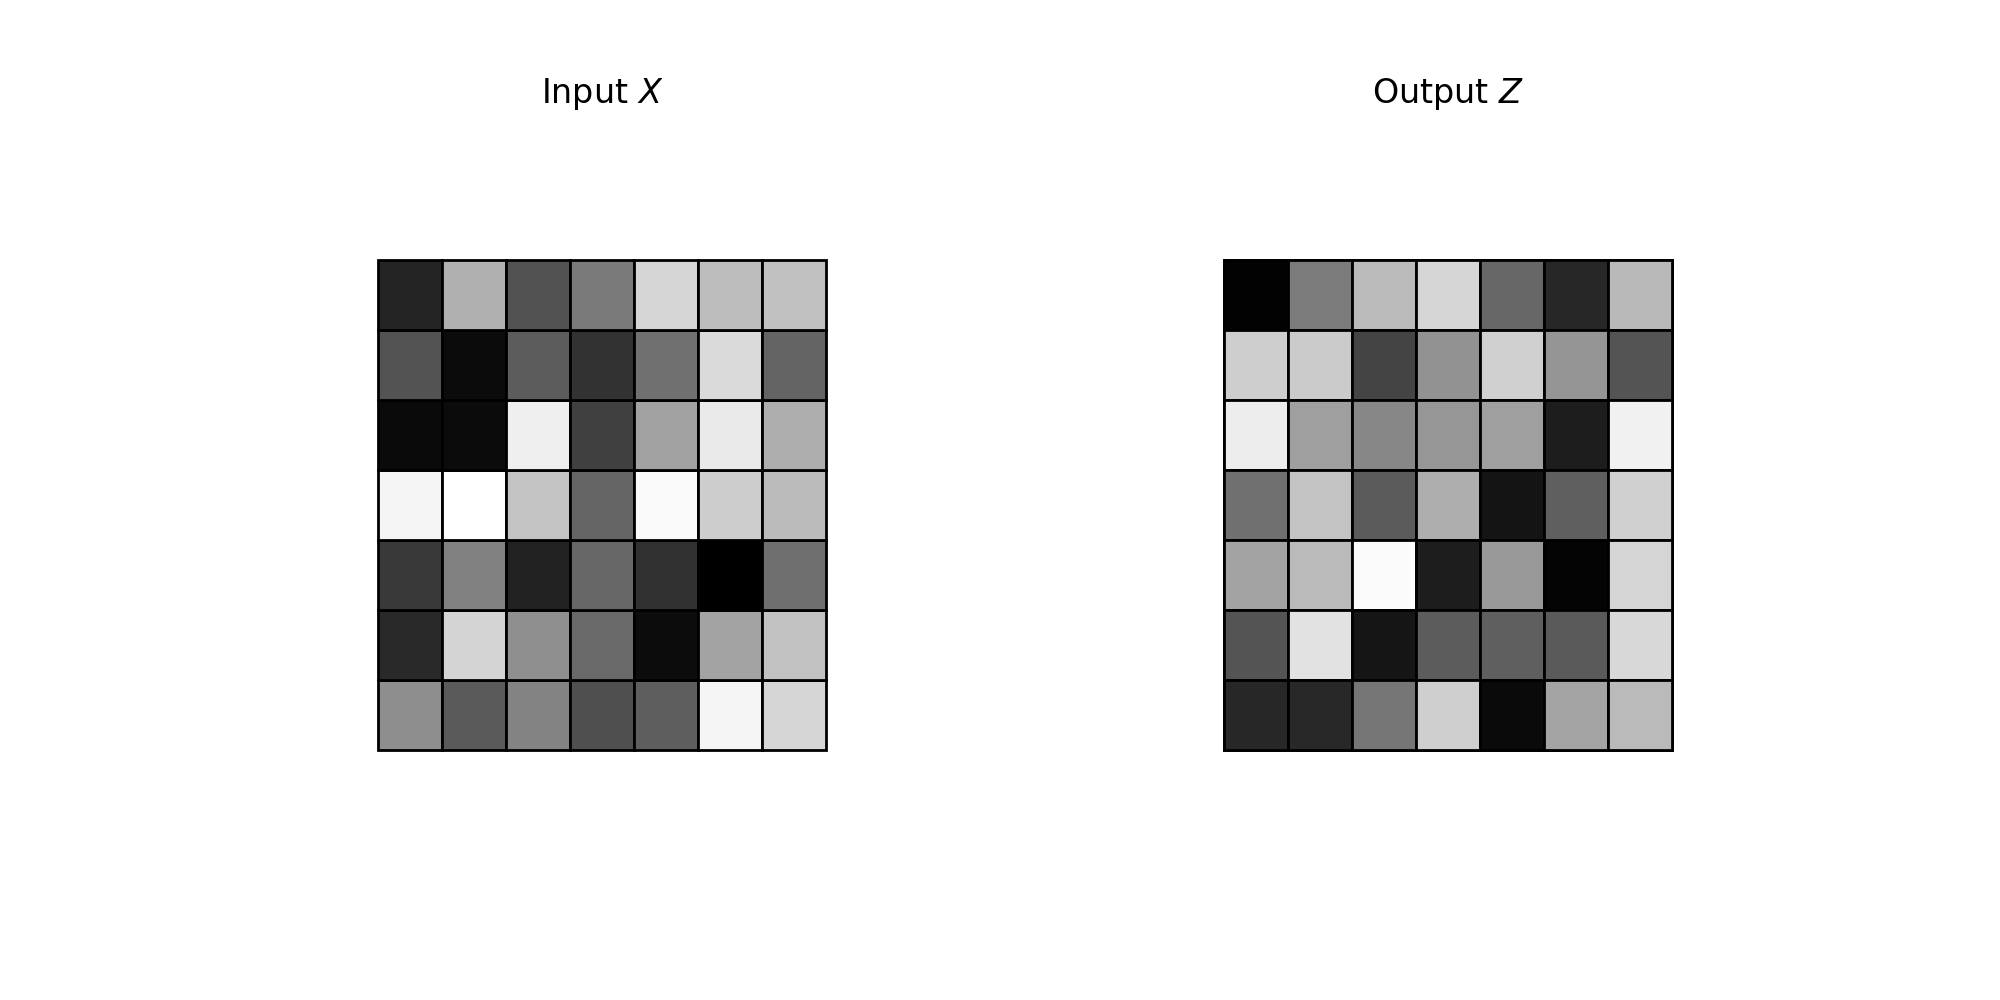

In [6]:
plots.conv_plot(kernel_size=5, stride=1, speed=10)

### Convolutional layer

Convolutional layers consist of multiple convolutional neurons. Each neuron creates its own output matrix - called a _channel_. If we start with a $256 \times 256$ image with 3 channels (RGB), the shape of this image is $256 \times 256 \times 3$. After we process it with 100 convolutional neurons, we get 100 new channels. The shape of the output of such convolutional layer is $256 \times 256 \times 100$. Each neuron looks at the same windows, but each neuron has its own parameters (weights and bias) and the activation values they calculate for their channels are therefore different.

The number of weight parameter in a convolutional layer can be calculated as $K \times C_i \times C_o$, where $K$ is a kernel size (e.g. 9 for $3 \times 3$ kernel), $C_i$ is number of channels on input and $C_o$ is number of channels on output or number (which is the same as number of neurons in the layer. If we have $3 \times 3$ kernel with 100 neurons over RGB image, the number of parameters in that layer is 2700. The next layer with 100 neurons would have $3 \times 3 \times 100 \times 100 = 90,000$ parameters. We omitted bias parameters, but each neuron has one.

### Max-pooling layer

Apart from convolutional layers, convolutional neural networks also contain max-pooling layers. These layers are very simple, we split each channel into small windows called _pools_, e.g. with a size of $2 \times 2$. From each pool we select only the maximum value. We construct new channel from these maxima:

<img src="images/max.svg" alt="Max-pooling" style="width: 30%; margin: 2em auto;"/>
<center><small>2x2 max-pooling applied over 8x8 input. Red border shows individual pools. From each pool the maximum value is selected for output.</small></center>

Max-pooling layers also have stride, similarly to convolutional layers. When we have the same stride as pool size, we reduces the dimensionality of the tensors in the network, e.g. we reduce $256 \times 256 \times 100$ into $128 \times 128 \times 100$ with $2 \times 2$ pools and $2 \times 2$ strides. But it also effectively increases the receptive field of the neurons. In deep networks, the receptive fields of the neurons from the later layers consist of the entire input image. Because each max-pooling halves width and height we usually use images with powers of two as dimensions.

<img src="images/receptive_field.svg" alt="Receptive field" style="width: 100%; margin: 2em auto 1em;"/>
<center><small>Receptive field of neuron calculating a pixel value shaded in blue. We can see that only after three layers (convolutional 3x3, max-pooling 2x2, convolutional 3x3), the receptive field w.r.t. original image is quite large. By chaining multiple max-pooling layers, the receptive field would only grow. Red and orange mark the receptive fields across neighbouring layers.</small></center>

### Convolutional neural network

CNNs consist of convolutional and max-pooling layers. Then the final layers are _dense_, i.e. the layers we used in MLP. The illustration below shows how convolutional neural network usually looks like. This is an architecture called VGG-16 [1]:

<img src="images/vgg16.jpg" alt="VGG-16" style="width: 60%; margin: 5em auto 0;"/>
<center><small>VGG-16 architecture as depicted by <a href="https://neurohive.io/en/popular-networks/vgg16/">Muneeb ul Hassan for Neurohive.</a></small></center>

You can see that CNNs are quite deep compared to MLP. Notice how the number of channels grow as the size of the image shrinks. This pyramid shape is how CNNs are usually designed. VGG-16 is quite popular architecture that is still used in practice as a baseline solution.

__Exercise 7.2:__ Check [this online visualization](https://scs.ryerson.ca/~aharley/vis/conv/) of how a very simple CNN works on a digit recognition task. Try to identify the basic parts we talked about so far - channel, convolutional layer, max pooling layer, dense layer.

### Training convolutional neural network

Convolutional neural networks are trained in the same way as the other neural networks we have seen so far, i.e. via _stochastic gradient descent_. Each neuron has a set of parameters and we calculate the derivative for each of these parameters w.r.t. defined loss function. The training is not so different from a MLP training, because convolution can be in fact [rewritten as matrix multiplication](https://github.com/alisaaalehi/convolution_as_multiplication), which is the basic operation of MLP as well.

It is interesting to think about what exactly are neurons learning in CNNs. The convolutional layers are quite small compared to dense layers and the neurons are always looking at just small windows. How is it possible that they can process images so well? The illustration below shows, what are neurons at individual layers learning:

<img src="images/neuron_vis.png" alt="Feature visualization" style="margin: 3em auto 0;"/>
<center><small>Visualization of what various neurons in CNN layers learned. Adapted from a <a href="https://distill.pub/2017/feature-visualization">Distill paper by C. Olah et al.</a> [2].</small></center>

We can see that the bottom-most layers are learning only very rudimentary patterns - edges, corners, etc. As we go further in the network, the neurons are combining what the neurons from previous layers learned and they become sensitive to more and more complex patterns. Finally the neurons in final layers are sensitive to very high-level patterns, e.g. pictures of dogs. I recommend checking the paper [2] to see some additional visualizations.

### TensorFlow example

Implementing CNNs in TensorFlow is quite straightforward, both convolutional and max-pooling layer are provided as `keras` layers. Check the code below that is used to classify pictures of fashion to different categories. You can also read the official [TensorFlow tutorial concerned with CNNs](https://www.tensorflow.org/tutorials/images/cnn). There are also additional tutorials about image processing in the same section.

First, lets download Fashion MNIST dataset and visualize some samples:

4423680/4422102 [==============================] - 2s 0us/step
Ankle boot


<IPython.core.display.Javascript object>


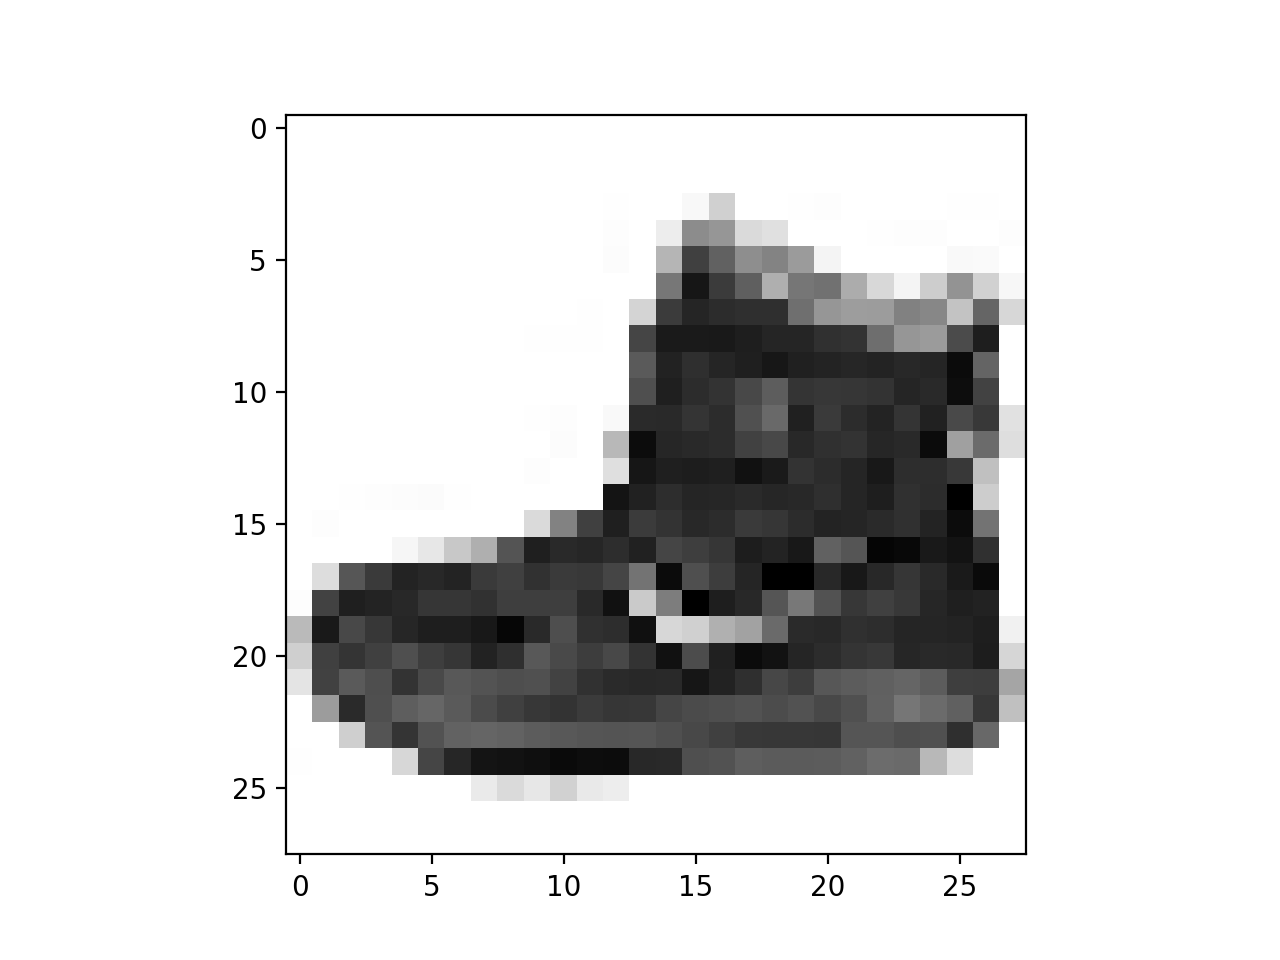

T-shirt/top


<IPython.core.display.Javascript object>


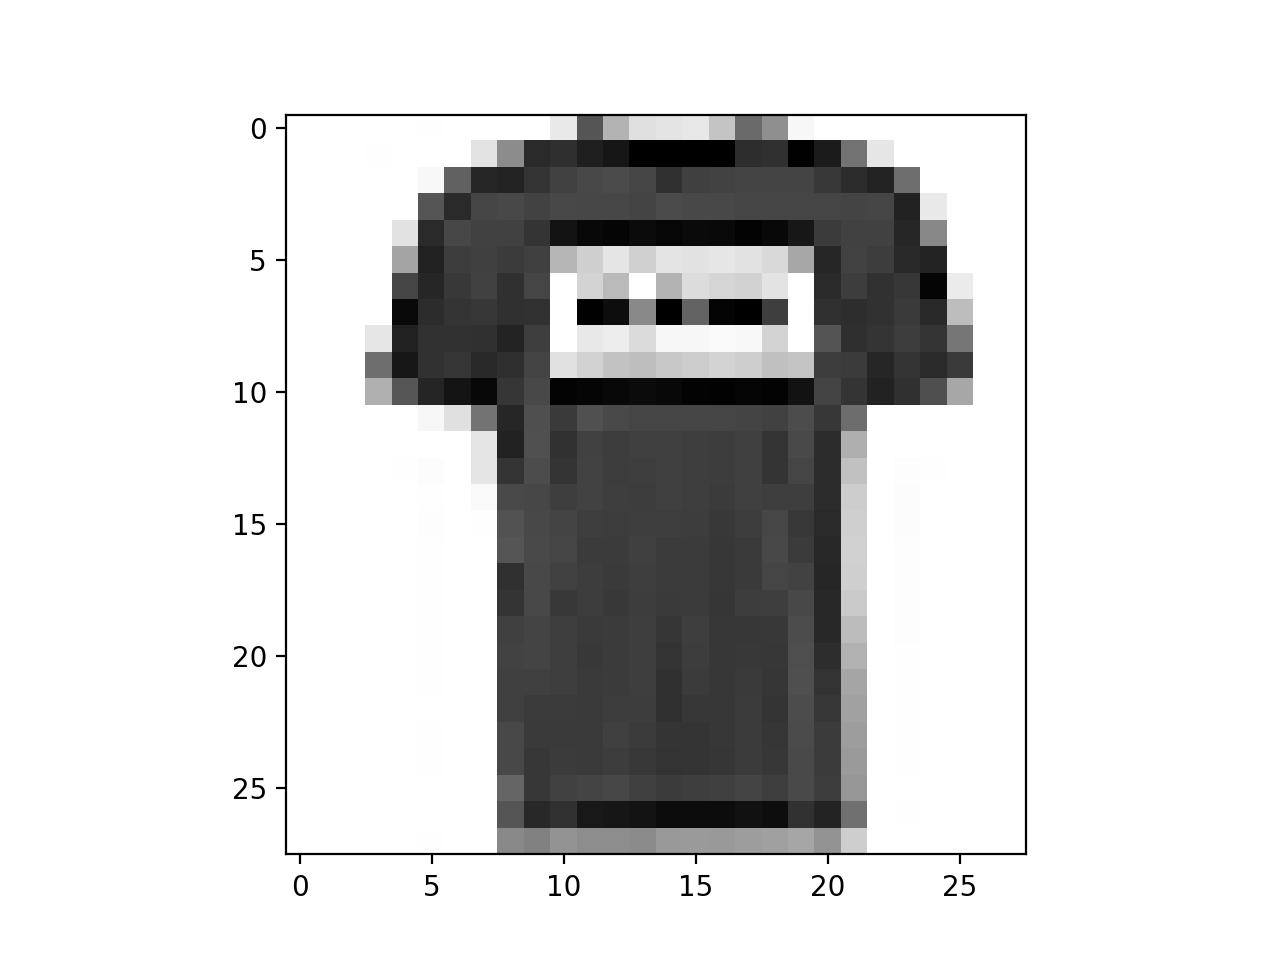

T-shirt/top


<IPython.core.display.Javascript object>


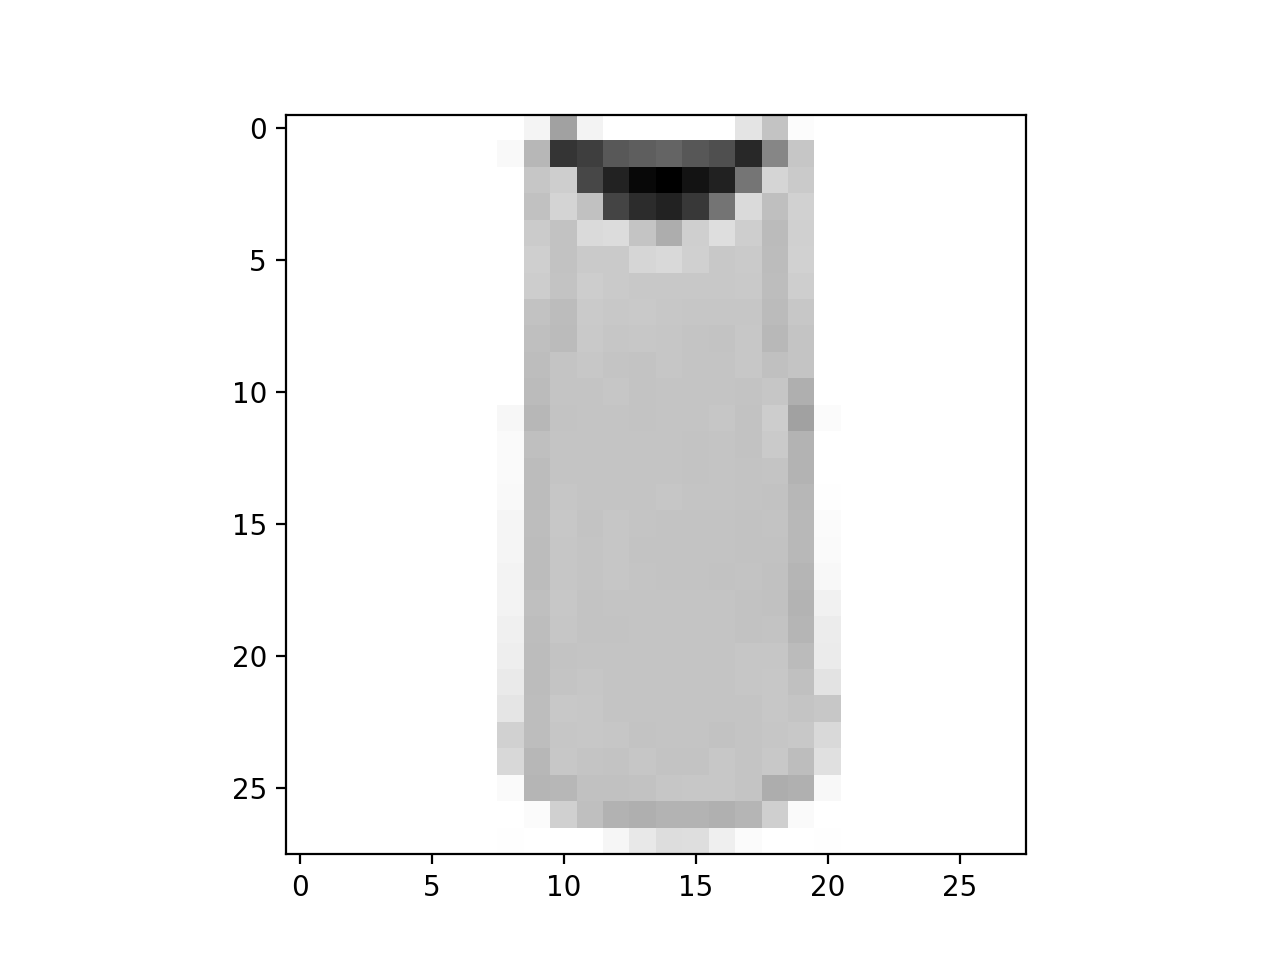

In [7]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for _, image, label in zip(range(3), train_images, train_labels):  # Takes 3 samples.
    print(class_names[label])
    plt.figure()
    plt.imshow(image, cmap='Greys')
    plt.grid(False)
    plt.show()


Then we do a slight pre-processing. First, we scale the input from $\langle 0-255 \rangle$ integer into $\langle 0.0, 1.0 \rangle$ float scale. Then we add a dimension to the images, so instead of $28 \times 28$, they have a shape of $28 \times 28 \times 1$. CNNs are used to work with channels, so even if we have only one channel, we need to explicitly use it as such.

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)


Next, we will define our own CNN `keras` model with ready-to-use layers, such as Conv2D, MaxPooling2D, etc.

In [9]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

class ConvolutionalNeuralNetwork(keras.Model):
    
    def __init__(self, dim_output):
        super(ConvolutionalNeuralNetwork, self).__init__(name='convolutional_neural_network')
        
        self.model_layers = [
            Conv2D(
                filters=16,  # Number of neurons
                kernel_size=3,
                padding='same',  # 'same' for zero padding, 'valid' for no padding
                activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(
                filters=32,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(
                filters=64,
                kernel_size=3,
                padding='same',
                activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),  # Flatten the sample from (width x height x channel) 3D matrix into a simple array.
                        # We need to use it for the dense layer.
            Dense(
                units=512,
                activation='relu'),
            Dense(
                units=dim_output,
                activation='softmax')        
        ]

    def call(self, x):
        for layer in self.model_layers:
            x = layer(x)
        return x

Finally we define the training procedure. Nothing exciting is hapenning here, training is very similar to a normal MLP.

In [10]:
model = ConvolutionalNeuralNetwork(
    dim_output=len(class_names))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Same as categorical_crossentropy, but we can have
                                             # category_id as label instead of one-hot representation.
    metrics=['accuracy'])

callbacks = [
    keras.callbacks.TensorBoard(
        log_dir=os.path.join("logs", timestamp()),
        histogram_freq=1,
        profile_batch=0)
]

# callbacks = []  # If you do not want to log results into TensorBoard

model.fit(
    x=train_images,
    y=train_labels,
    batch_size=16,
    validation_data=(test_images, test_labels),
    callbacks=callbacks,
    epochs=30)

model.summary()  # Writes number of parameters for each layer at the end of the training


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 37s 620us/sample - loss: 0.4140 - accuracy: 0.8471 - val_loss: 0.3543 - val_accuracy: 0.8759
Epoch 2/30
60000/60000 [==============================] - 36s 597us/sample - loss: 0.2722 - accuracy: 0.8986 - val_loss: 0.2686 - val_accuracy: 0.9033
Epoch 3/30
60000/60000 [==============================] - 33s 546us/sample - loss: 0.2310 - accuracy: 0.9133 - val_loss: 0.2657 - val_accuracy: 0.9024
Epoch 4/30
60000/60000 [==============================] - 32s 540us/sample - loss: 0.2042 - accuracy: 0.9230 - val_loss: 0.2519 - val_accuracy: 0.9087
Epoch 5/30
60000/60000 [==============================] - 36s 601us/sample - loss: 0.1796 - accuracy: 0.9330 - val_loss: 0.2503 - val_accuracy: 0.9099
Epoch 6/30
60000/60000 [==============================] - 34s 571us/sample - loss: 0.1610 - accuracy: 0.9380 - val_loss: 0.2649 - val_accuracy: 0.9141
Epoch 7/30
60000/60000 [====================

KeyboardInterrupt: 

__Exercise 7.3:__ We trained the standard CNN defined above for 30 epochs. The run is called `vanilla` and you can find how it trained in your TensorBoard. Review the _10. From train to test_ section from [the previous week's lab](http://127.0.0.1:8888/notebooks/week_6/week_6.ipynb). In what point of growing our model are we?

### Combining layers

Above we defined a typical feed-forward neural network. Each layer sees only the previous layer and nothing else. Sometimes we combine multiple layers to improve the results. For example, we might take two convolutional layers, one with $3 \times 3$ kernel size and the other with $5 \times 5$ kernel size and combine their channels:

```python
from tf.keras.layers import Concatenate

# In CNN __init__

    self.conv1 = Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu')
    self.conv2 = Conv2D(
        filters=64,
        kernel_size=5,
        padding='same',
        activation='relu'),
        
# In CNN call

    x = ...                    # (width, height, 32) <- shape
    c1 = self.conv1(x)         # (width, height, 64)
    c2 = self.conv2(x)         # (width, height, 64)
    x = Concatenate([c1, c2])  # (width, height, 128)
```

If the original `x` has dimensions $256 \times 256 \times 32$, each convolutional layers creates its own set of channels with dimension $256 \times 256 \times 64$ and after we concatenate them together, we simply stack them together on top of each otehr into a $256 \times 256 \times 128$ shape.

Similarly, we can concatenate the output of the layer with its input. This technique is called _residual_ connections or _skip_ connections. The main idea behind this technique is that we do not want to lose the information that was learned by the previous layers, we want to keep it untouched for further layers.

```python
# In CNN __init__

    self.conv1 = Conv2D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu')
        
# In CNN call

    x = ...                   # (width, height, 32)
    c1 = self.conv1(x)        # (width, height, 64)
    x = Concatenate([x, c1])  # (width, height, 96)
```

### Programming Assignment 7.4: Inception Module [2pts]

_Inception module_ is a specific layer used for convolutional neural networks. It was designed at Google and over the years it has had several versions. It uses the concept of combining convolutional layers with different kernel sizes. Below is depicted the first version of Inception module proposed in 2014:

<img src="images/inception_layer.png" alt="Inception layer" style="width: 70%; margin: 3em auto 0;"/>
<center><small>Inception layer v1. Adapted from a <a href="https://ai.google/research/pubs/pub43022">CVPR paper by Ch. Szegedy et al.</a> [3].</small></center>

This layer was then used in a network architecture called GoogLeNet, which was quite successful at the time. You can see the individual Inception modules in the illustration below:

<img src="images/googlenet.png" alt="GoogLeNet" style="width: 70%; margin: 3em auto 0;"/>
<center><small>GoogLeNet. Adapted from a <a href="https://ai.google/research/pubs/pub43022">CVPR paper by Ch. Szegedy et al.</a> [3].</small></center>

Your task is to implement your own Inception module as a `keras` Layer. Check the `inception.py` file for further instructions.

__Submission:__ Submit the completed `inception.py` file along with TensorBoard logs from training your Inception-based neural network into AIS. Please, use `.zip` to package the files. You can validate your solution manually - if you run the `model.summary` command it should say that you have `335,210` parameters in your model.


In [15]:
from inception import InceptionNet

model = InceptionNet(
    filters=16,
    dim_output=len(class_names))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

callbacks = [
    keras.callbacks.TensorBoard(
        log_dir=os.path.join("logs", timestamp()),
        histogram_freq=1,
        profile_batch=0)
]

model.fit(
    x=train_images,
    y=train_labels,
    batch_size=16,
    validation_data=(test_images, test_labels),
    callbacks=callbacks,
    epochs=5)  # 30 epochs is quite a lot if you want to comute this on CPU. You do not have to finish 30 epochs
                # for your submission.
    
# My implementation of the Inception layer was just slightly better (+1% acc) than standard CNN. Inception layers
# star to shine mainly in bigger networks. In addition, they are mainly designed to handle images where the object
# of interest can be located in whatever part of the image. In Fashion MNIST all the object are centered and scaled.

model.summary()

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 152s 3ms/sample - loss: 0.4156 - accuracy: 0.8475 - val_loss: 0.3200 - val_accuracy: 0.8806
Epoch 2/5
60000/60000 [==============================] - 150s 3ms/sample - loss: 0.2812 - accuracy: 0.8963 - val_loss: 0.2817 - val_accuracy: 0.8963
Epoch 3/5
60000/60000 [==============================] - 145s 2ms/sample - loss: 0.2411 - accuracy: 0.9098 - val_loss: 0.2616 - val_accuracy: 0.9017
Epoch 4/5
60000/60000 [==============================] - 154s 3ms/sample - loss: 0.2138 - accuracy: 0.9186 - val_loss: 0.2595 - val_accuracy: 0.9064
Epoch 5/5
60000/60000 [==============================] - 150s 2ms/sample - loss: 0.1931 - accuracy: 0.9279 - val_loss: 0.2501 - val_accuracy: 0.9110
Model: "inception_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_12 (Inception)     multiple           

#### 1D and 3D convolution

So far we have discussed only 2D convolution. The input has two dimensions - width and height - and for each pixel we have several channels. We can use the same principle in 1D case, e.g. we can have a time series where each point in time has several features - channels. The 1D convolution is very similar to 2D convolution, but instead of 2D convolutional kernels, 2D channels, 2D pools we have all these concepts in 1D. E.g. we will have a kernel size 5 that can see 5 steps in the time series. 1D convolution can be used to model time series, sounds, text and other sequential data. Similarly, we can have CNNs that can process 3D data, these are for example used in biomedicine for drug analysis.

## Regularization

_Bias_ and _variance_ are two very important machine learning concepts. Bias in this context is not a neuron parameter. Bias is a train set error. High bias means that we can not fit the train data very well. In Exercise 7.3 we have seen a training that was able to fit the training data with almost 100% accuracy. The bias of this model is very low.

Variance on the other hand is a test set error. It is the difference between train and test set data. In 7.3 the test set only achieved accuracy of about 91%. The 9% difference between train and test set performance is the variance of the model.

_Regularization_ is a term used for various techniques that reduce the _variance_ of the model. By reducing variance we often increase the bias - this is often referred to as a _bias-variance trade-off_. We try to tune the variance and bias so that we get the best possible test set results.

We will not explain in detail how individual regularization techniques work here. You can check the further reading section for in-depth explanation. Instead, we will shortly review how to apply common techniques in TensorFlow.

### L2  and  L1 regularization

Both L2 and L1 aim to reduce the magnitude of parameters. Each training step, optimizer calculates the gradient for each parameter. On top of that, both L2 and L1 slightly push each parameter towards the zero. This is based around the observation, that the parameters with high magnitude lead to unstable results.

L2 and L1 regularizators are applied on layers with trainable parameters, e.g. Dense and ConvXD layers. You can apply them simply by using the `x_regularizer` parameter during their initialization. Check the documentation of these layers for more detail. We usually apply these regularizators only on weights (weights are also called `kernel`) and not on biases. L2 is used more often than L1.

```python
from tf.keras.regularizers import l1, l2

dense = Dense(
    units=64, 
    activation='relu,
    kernel_regularizer=l2(l=0.01),  # l is lambda, how strong the regularizer is
    bias_regularizer=l2(l=0.01))

conv = Conv2D(
    filters=64,
    kernel_size=3,
    activation='relu',
    kernel_regularizer=l1(l=0.02))
```

### Dropout

Dropout randomly turns off certain number of neurons in a layer. This helps with generalization, because the model can not rely on a specific values from specific neurons. Instead, each neuron needs to be able to contribute to the result. Dropout is usually used only after _dense_ layers. It is implemented as `keras` Layer:

```python
from tf.keras.layers import Dropout

dense = Dense(
    units=64, 
    activation='relu)
dropout = Dropout(
    rate=0.5)  # How many neurons are turned off
    
x = dense(x)
x = dropout(x)
```

### Batch normalization

Batch normalization is a controversial technique. It empirically improves the results, but researchers are not quite sure why. We simply normalize each activation value within a batch. I.e. when we have a 200 neurons in a dense layer, we calculate the mean and variance of output for each neuron. Then we use these quantities to normalize the output. We can use batch normalization after both dense and convolutional layers

```python
from tf.keras.layers import BatchNormalization

dense = Dense(
    units=64, 
    activation='relu)
batchnorm = BatchNormalization()
    
x = dense(x)
x = batchnorm(x)
```

### Hyperparameters

All the regularization methods above introduce additional hyperparameters. Lambda `l` for L2 and L1, `rate` for dropout and [multiple hyperparameters](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) for batch normalization. Similarly to other hyperparameters these need to be tuned as well.

Lambda `l` is usually set to a small number, I would consider exponentially search through $\langle 10^{-4}, 10^{-2}$ range. For dropout rate a number from $\langle 0.1, 0.5$ range is usually used. I would typically use the default values for batch normalization, but you can tune them as well. L2/L1 is not as popular as it once was, because it is quite sensitive to how we set the lambda hyperparameter. Nowadays most people use either dropout and batch normalization as a single technique for their model.

__Exercise 7.5:__ Try to apply regularization techniques on the CNN model defined above. It might take quite a while to run all 30 epochs, but you can have it run in the background. Can you improve the test set results? It might be quite tricky, because CNNs usually do not require much regularization.

## Key Concepts from This Week

- Convolutional neuron
- Convolutional layer
- Channel
- Kernel
- Kernel size
- Stride
- Max-pooling layer
- Convolutional neural network
- Inception layer
- 1D convolution
- Regularization

## Further Reading

- Distill.pub is a journal that has a great series about CNN visualization: [first](https://distill.pub/2017/feature-visualization/), [second](https://distill.pub/2018/building-blocks/), [third paper](https://distill.pub/2019/activation-atlas/).
- [Notes from Stanford](http://cs231n.github.io/convolutional-networks/) provide additional details about why are CNNs designed the way they are. The notes also cover some additional advanced topics.
- Andrew Ng has a [short lecture about Bias and Variance](https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2) in his Deep Learning course on Coursera.
- Chapter 7 from Deep Learning book by I. Goodfellow et al. [4] covers many additional regularization techniques.

## Sources
[1] Simonyan, K., & Zisserman, A. (2015). Very deep convolutional networks for large-scale image recognition. 3rd International Conference on Learning Representations, ICLR 2015, San Diego, CA, USA.  
[2] Olah, C., Mordvintsev, A., & Schubert, L. (2017). Feature visualization. Distill, 2(11), e7.  
[3] Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A. (2015). Going deeper with convolutions. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1-9).  
[4] Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.

## Correct Answers

__E 7.3:__ We successfully finished the second phase - training with full training set. We are able to fit the training data with nearly 100% accuracy. The model is big enough to learn from the data and the training is quite stable. Next, we should focus on improving the performance for test set. Test set performance starts to stagnate quite early and the loss for this set even starts to increase. 